In [1]:
!date

Mon Aug 18 12:13:56 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

### Get Files

In [3]:
import os
import numpy as np
import pandas as pd
import ants

In [4]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models
importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1
numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1


In [5]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
#print(f'{len(subs)}/{len(subs_orig)}')
print(len(subs))

14


In [6]:
# Parameters for looping. 
s = 2 # index for subject (out of 14)
r = 1 # index for run (out of 4)
analysis_name = 'ABCD-adv-test' # This is be appended to the saved output files

In [7]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(f'{s}/{len(subs)}')
n_orig = len(subs)
sub = subs[s]
sub

2/34


'sub-NDARINV3385AZ13'

In [8]:
epi_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
anat_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
anat_gm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
anat_wm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
anat_csf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')
conf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')

In [9]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
anat = ants.image_read(anat_fn.format(sub=sub,r=r))
anat_gm = ants.image_read(anat_gm_fn.format(sub=sub,r=r))
anat_wm = ants.image_read(anat_wm_fn.format(sub=sub,r=r))
anat_csf = ants.image_read(anat_csf_fn.format(sub=sub,r=r))
df_conf = pd.read_csv(conf_fn,delimiter='\t')


In [10]:
## EPI parameters: Check that these are correct
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 8

print(f'Number of scans: {nTR}')
print(f'Repetition Time: {t_r}')
print(f'Dummy scans to discard: {ndummy}')

Number of scans: 370
Repetition Time: 0.8
Dummy scans to discard: 8


In [11]:
# Directory where to save the outputs
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test


## Post-training analyses

In [12]:
events_fn = os.path.join(events_fn)
X1 = get_design_matrix(epi,events_fn)
X1

,0_back_negface,0_back_neutface,0_back_place,0_back_posface,2_back_negface,2_back_neutface,2_back_place,2_back_posface,cue,dummy,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.50000,0.166215,-0.049594,1.0
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000189,-0.49729,0.163512,-0.047981,1.0
1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.006770,-0.49458,0.160824,-0.046391,1.0
2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041190,-0.49187,0.158151,-0.044821,1.0
3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.123477,-0.48916,0.155492,-0.043274,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072873,0.0,0.000000,0.48916,0.155492,0.043274,1.0
292.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061511,0.0,0.000000,0.49187,0.158151,0.044821,1.0
293.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.050801,0.0,0.000000,0.49458,0.160824,0.046391,1.0
294.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.041046,0.0,0.000000,0.49729,0.163512,0.047981,1.0


In [13]:
# If no post-training analyses needed, leave these empty
correlation_analyses = []
contrast_analyses = []

In [14]:
correlation_analyses.append(
    {'corr_target' : X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_neutface','2_back_posface']].values.mean(axis=1),
     'filename_temp' : os.path.join(ofdir,'corr2face_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

correlation_analyses.append(
    {'corr_target' : X1[['0_back_place','2_back_place']].values.sum(axis=-1),
     'filename_temp' : os.path.join(ofdir,'corr2place_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

contrast_analyses.append(
    {'contrast_vec' : [1,1,-3,1,1,1,-3,1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename_temp' : os.path.join(ofdir,'contrast_face_{s}_R{r}_{aname}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

contrast_analyses.append(
    {'contrast_vec' : [-1,-1,3,-1,-1,-1,3,-1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename_temp' : os.path.join(ofdir,'contrast_place_S{s}_R{r}_{aname}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

In [15]:
# Model Hyperparameters
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 20
hyperparams_cvae['epoch_num'] = 100
hyperparams_cvae['batch_size'] = 8192
hyperparams_cvae['latent_dim'] = 8 #(8,8) # Shared,Specific
#hyperparams_cvae['beta'] = 0.01      
hyperparams_cvae['beta'] = 1e-5
hyperparams_cvae['gamma'] = 1 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

# END of user-specified parameters

In [16]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)
epi,df_conf = apply_frame_censoring(epi,df_conf,df_conf['framewise_displacement'].values>.9,also_nearby_voxels=True)

Censored 0.00% of voxels 0/370


In [17]:
use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
#use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(370, 138)


,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


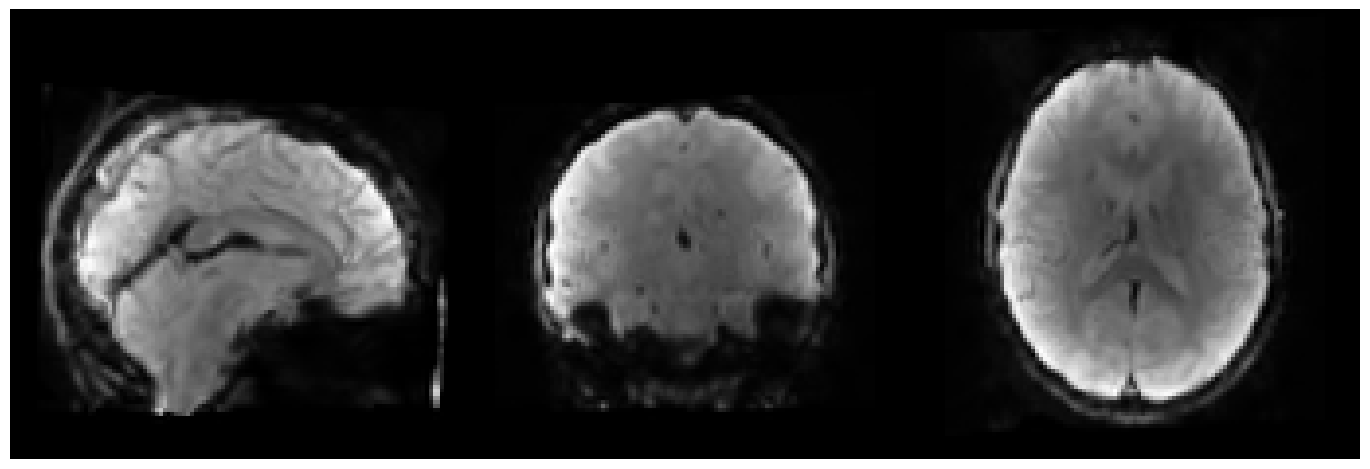

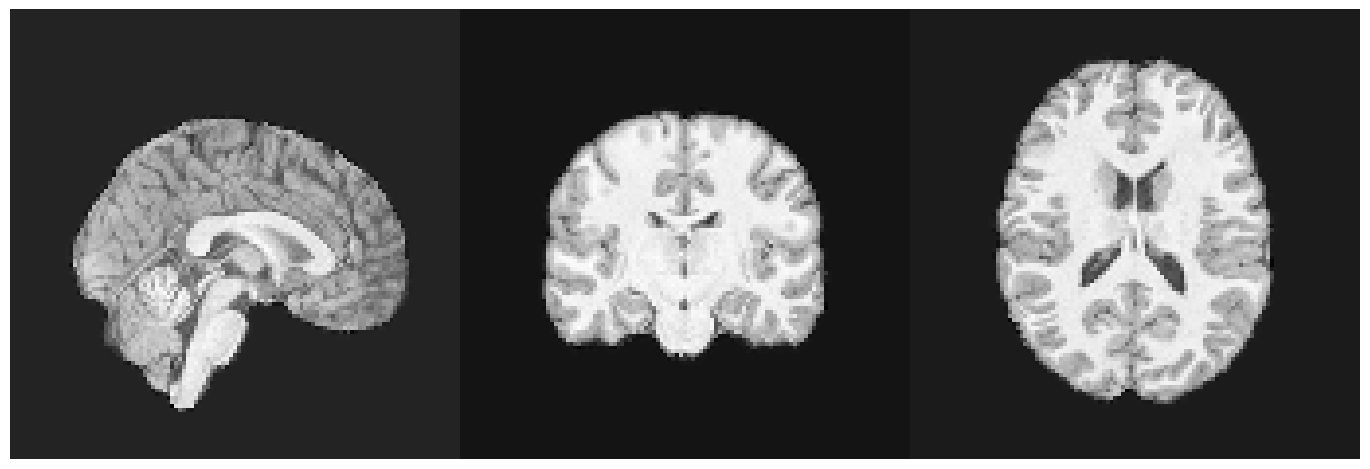

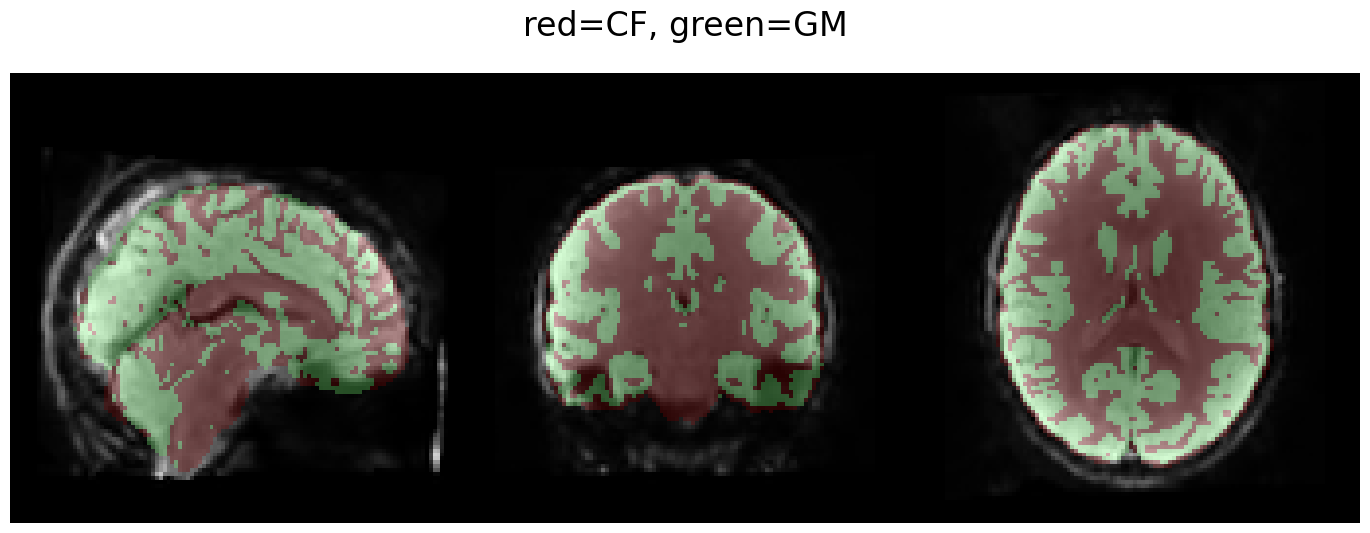

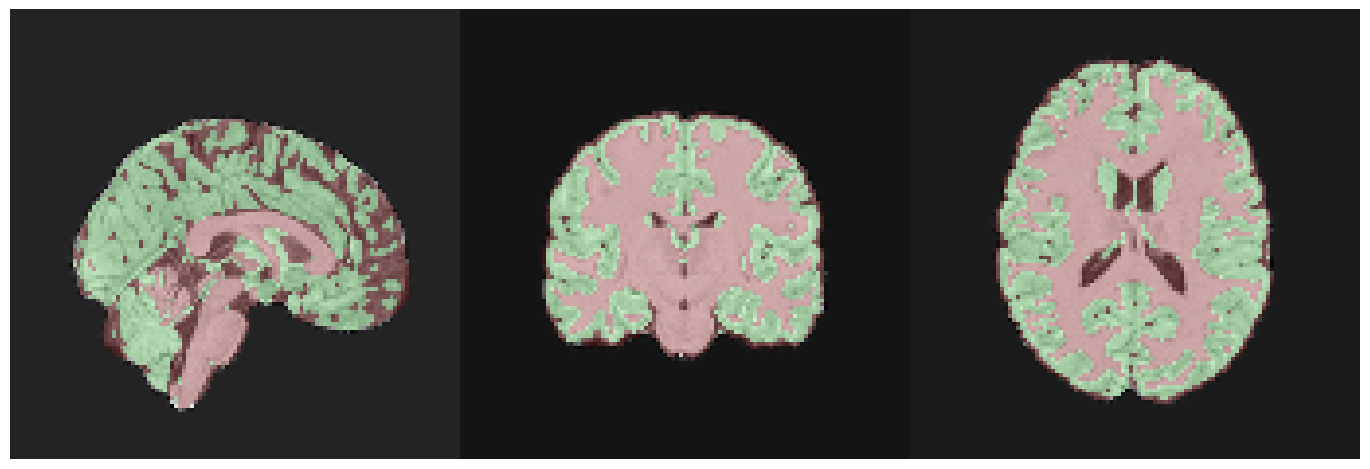

In [18]:
gm,cf = get_roi_and_roni(epi,anat,anat_gm,anat_wm,anat_csf,do_plot=True) # If using individual masks

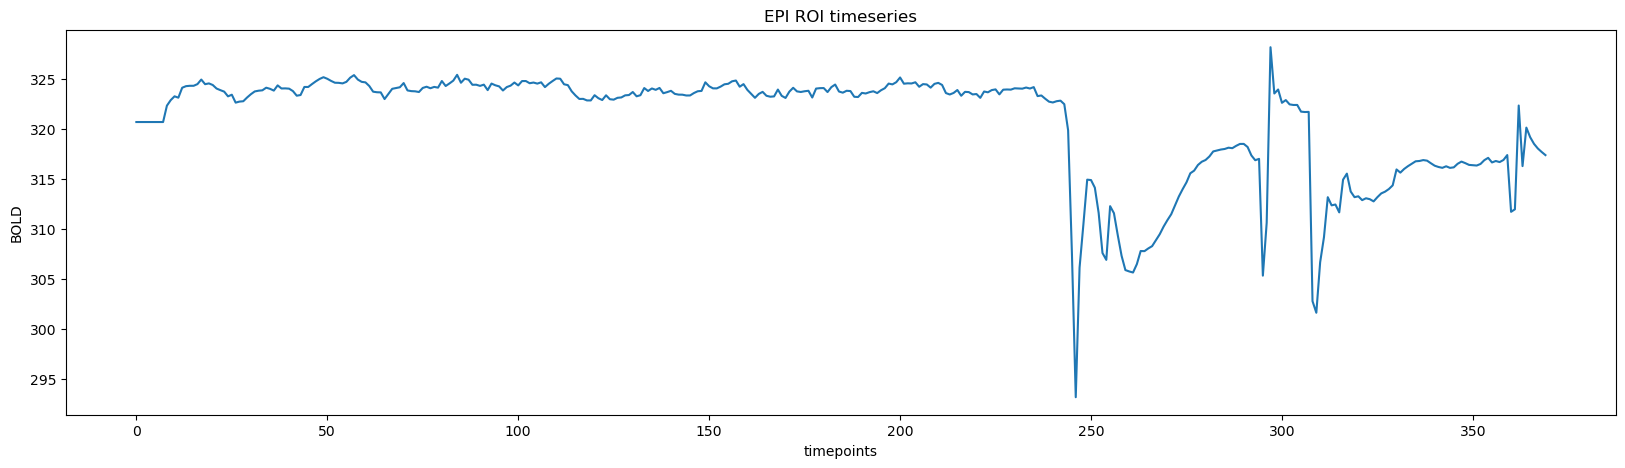

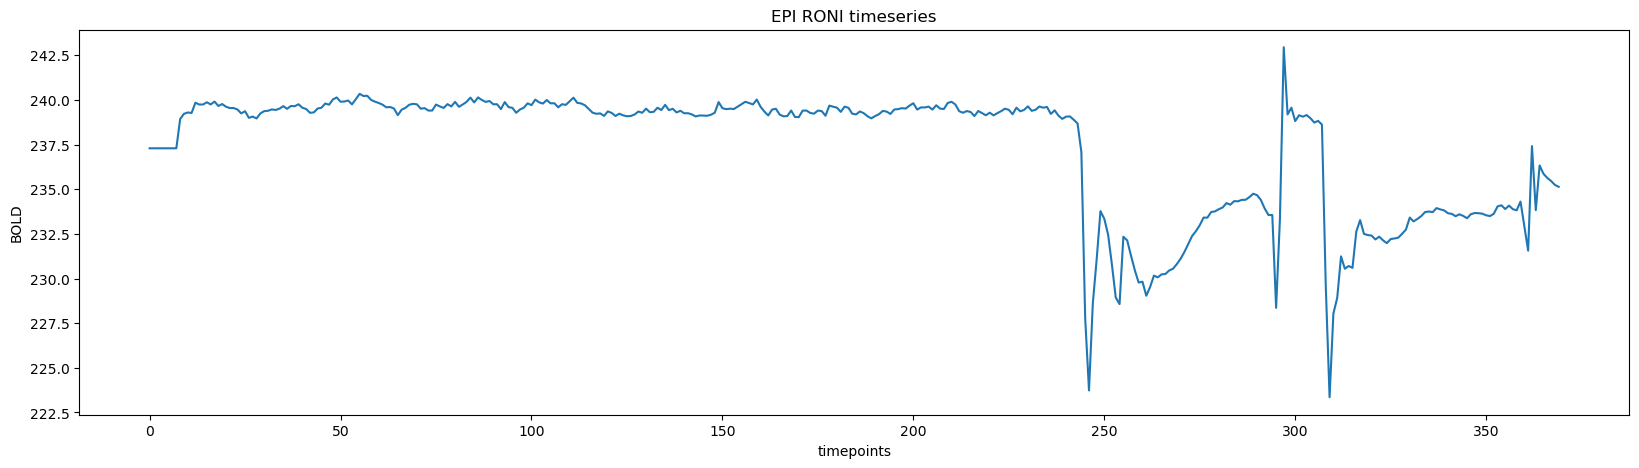

In [19]:
plot_timeseries(epi,gm,cf)

Text(0.5, 1.0, "['a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']")

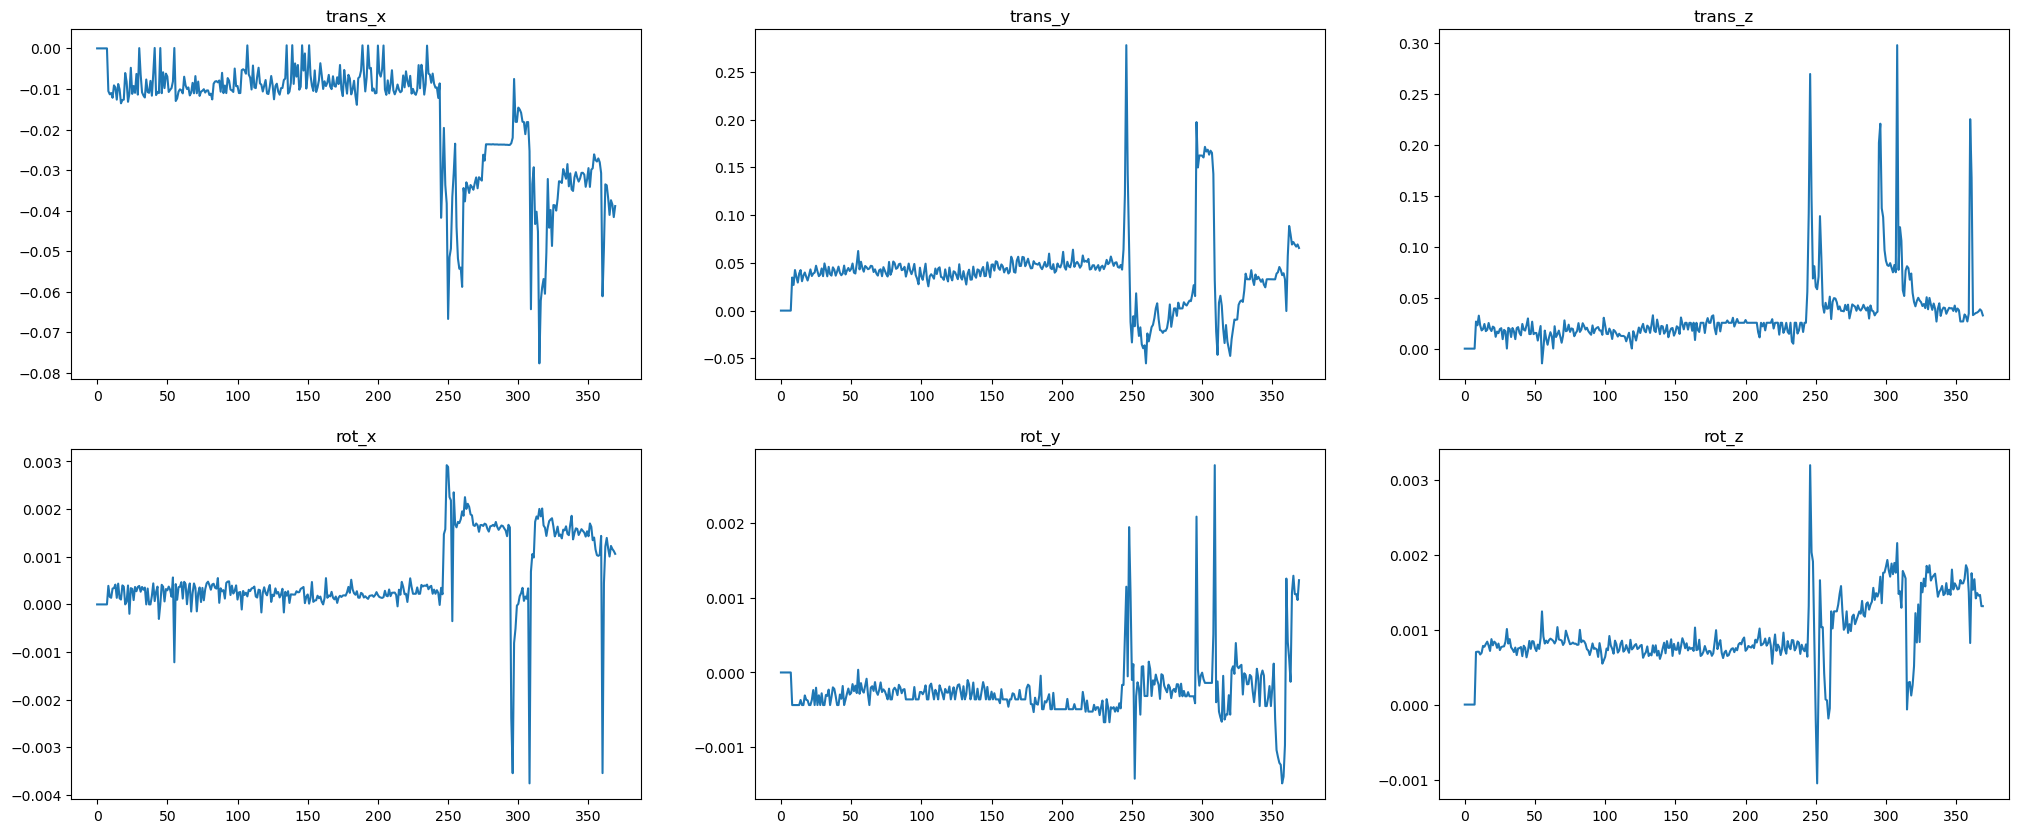

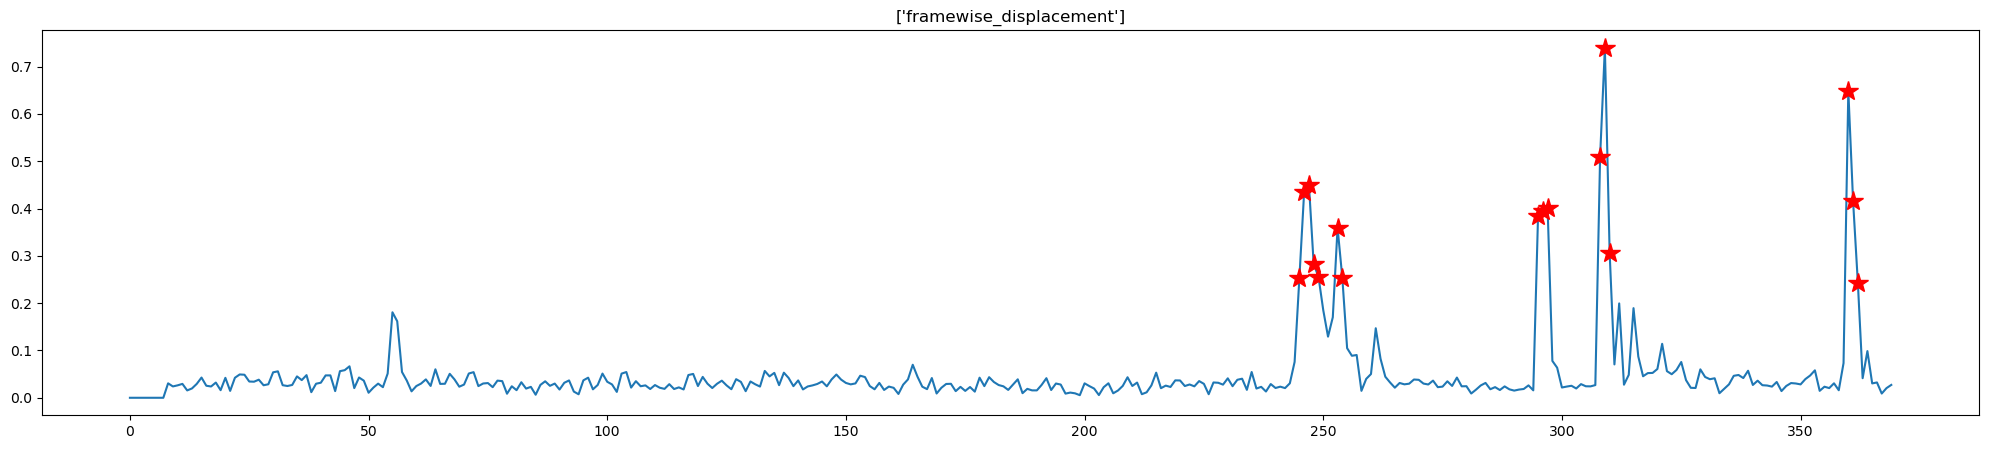

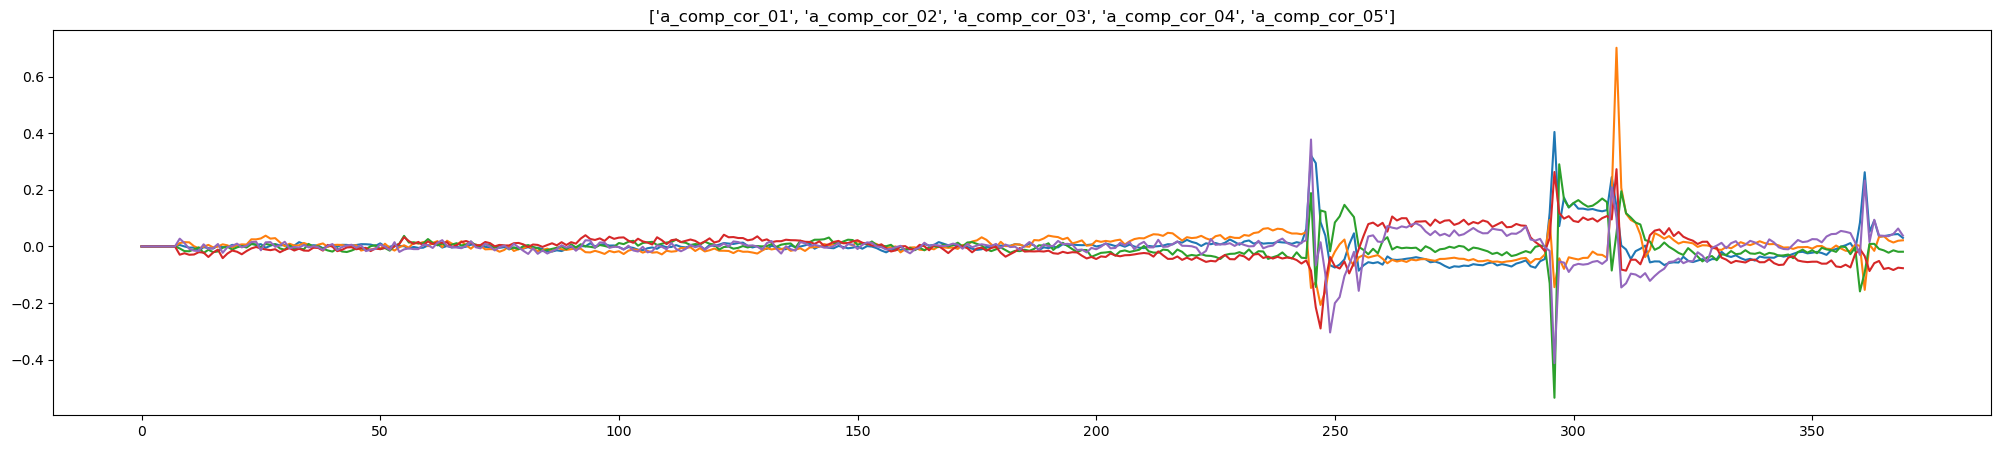

In [20]:
conf_keys = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
#conf_keys = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
conf_keys = ['framewise_displacement']
#conf_keys = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys].values)
thresh=.2
vec = (df_conf[conf_keys].values>thresh)*1.0*df_conf[conf_keys].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys)

plt.figure(figsize=(25,5))
#conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04']
#conf_keys = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys].values)
plt.title(conf_keys)

In [21]:
def get_brain_signal(model,train_inputs,epi,gm,inv_z_score=True):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    gm_flat = gm.numpy().flatten()
    
    train_in_coords = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=False)
    dataloader_iter_in = iter(train_in_coords)
    brain_signals = []
    for _ in range(len(train_in_coords)):
        inputs_gm, inputs_cf = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        fg_signal = model.forward(inputs_gm)[0].detach().cpu().numpy()
        fg_signal = fg_signal[:,0:epi.shape[-1]]
        brain_signals.append(fg_signal)
    
    # Reconstruct the full brain array
    brain_signals_arr = np.zeros(epi_flat.shape)
    assert np.vstack(brain_signals).shape[0]==gm_flat.sum(), 'mismatch in voxel sizes: {}/{}'.format(np.vstack(brain_signals).shape[0],gm_flat.sum())
    
    brain_signals = np.vstack(brain_signals)
    
    if inv_z_score==True:
        epi_mean = epi_flat[gm_flat==1,:].mean(axis=1)
        epi_std = epi_flat[gm_flat==1,:].std(axis=1)
        brain_signals = (brain_signals*epi_std[:,np.newaxis]+epi_mean[:,np.newaxis]) # Invert z-scoring
        
    valid_voxels = gm_flat==1
    brain_signals_arr[valid_voxels, :] = brain_signals
    brain_signals_arr = brain_signals_arr.reshape(epi.shape)
    brain_signals_img = epi.new_image_like(brain_signals_arr)

    return brain_signals_img

In [22]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

obs_list_coords.shape: (122141, 4, 370)
noi_list_coords.shape: (113738, 4, 370)
upsampling noi_list_coords
obs_list_coords.shape: (122141, 4, 370)
noi_list_coords.shape: (122141, 4, 370)


In [23]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [24]:
# Run some sanity check, for flat voxels (not good for training) and NaNs
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [26]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
nreps = nrep
epoch_num = hyperparams_cvae.get('epoch_num',100)
n_epochs = epoch_num
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
lr = hyperparams_cvae.get('lr',0.001)

In [27]:
import models
import utils
import datasets
import dashboard

running rep 1: 2025-08-18 12:15:21.014663


100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  3.44it/s]


running rep 2: 2025-08-18 12:16:04.368648


100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  3.23it/s]


running rep 3: 2025-08-18 12:16:48.172647


100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  3.41it/s]


running rep 4: 2025-08-18 12:17:31.708244


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  3.67it/s]


[]
Ensemble of 5 repetitions


100%|█████████████████████████████████████████████| 5/5 [00:49<00:00,  9.87s/it]


signals averaged: 5
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2face_S2_R1_conv_denoise_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2face_S2_R1_conv_denoise_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2face_S2_R1_conv_denoise_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2place_S2_R1_conv_denoise_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2place_S2_R1_conv_denoise_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/corr2place_S2_R1_conv_denoise_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/contrast_face_2_R1_conv_denoise_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/contrast_face_2_R1_conv_denoise_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-adv-test/contrast_face_2_R1_conv_denoise_de

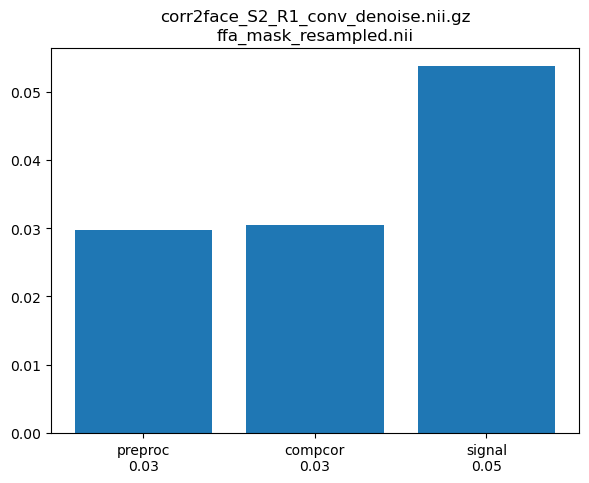

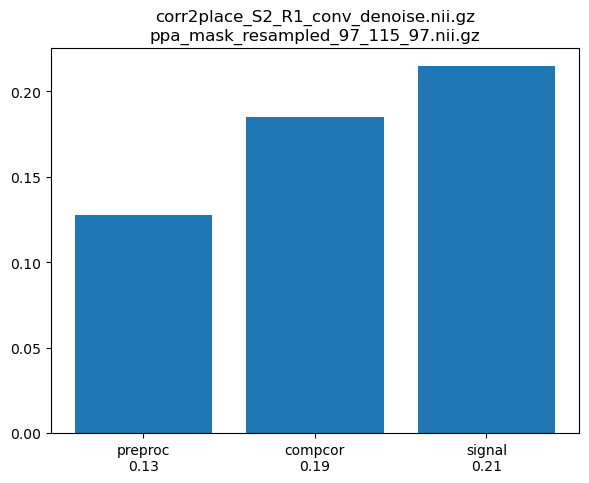

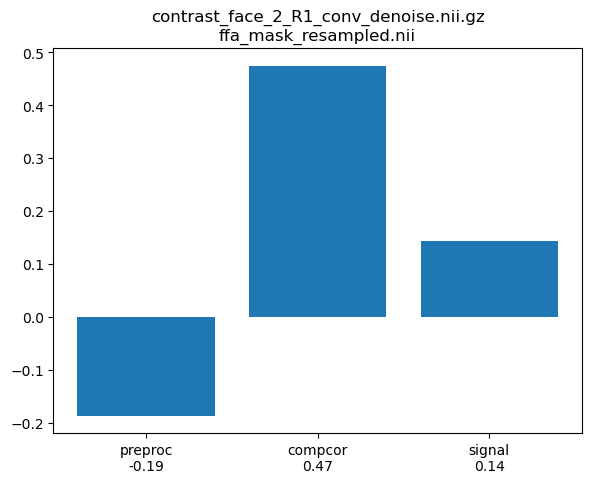

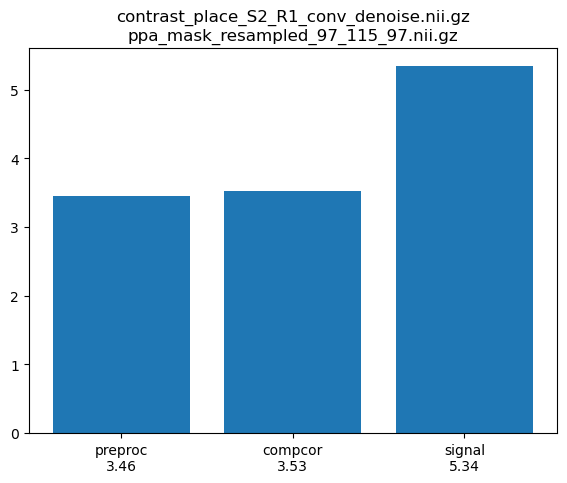

In [30]:
aname = 'conv_denoise'
n_epochs = 100
errors=[]
for rep in range(nreps):
    if not os.path.exists(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz')):
        print(f'running rep {rep}: {datetime.now()}')
        try:
            torch.cuda.empty_cache()
            torch.cuda.init()
            
            train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
            train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
            
            model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
            model.to(device);
            optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
            
            track = {}
            loss_L = []
            loss_signal_L = []
            loss_noise_L = []
            for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
                dataloader_iter_in = iter(train_in)
                running_loss = 0
                running_loss_signal = 0
                running_loss_noise = 0
                #for i in range(len(train_in)):           
                for i in range(len(train_in)):
                    optimizer.zero_grad()
                    inputs_gm,inputs_cf = next(dataloader_iter_in)
                    inputs_gm = inputs_gm.float().to(device)
                    inputs_cf = inputs_cf.float().to(device)[:,0,:]
                    [sig, noise] = model.forward(inputs_gm)
                    loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
                    loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
                    loss = loss_ncc+loss_mse
                    loss_signal = loss_signal_ncc+loss_signal_mse
                    loss_noise = loss_noise_ncc+loss_noise_mse
                    if np.isnan(loss.detach().cpu().numpy()):
                        print('loss is NaN')
                        break
                    loss.backward()
                    optimizer.step()
                    running_loss += loss
                    running_loss_signal += loss_signal
                    running_loss_noise += loss_noise        
                epoch_loss = running_loss / len(train_in)
                epoch_loss_signal = running_loss_signal / len(train_in)
                epoch_loss_noise = running_loss_noise / len(train_in)
                loss_L.append(epoch_loss.detach().cpu().numpy())
                loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
                loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
                track['loss_L'] = loss_L
                track['loss_signal_L'] = loss_signal_L
                track['loss_noise_L'] = loss_noise_L
            
            brain_signal = get_brain_signal(model,train_inputs,epi,gm)
            brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
            save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)
        except:
            errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
            traceback.print_exc()
print(errors)
signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
print('Ensemble of {} repetitions'.format(len(signal_files)))
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

for analysis_spec in correlation_analyses:
    analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
    run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

for analysis_spec in contrast_analyses:
    analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
    run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [31]:
# aname = 'conv_denoise_long'
# n_epochs = 200
# errors = []
# for rep in range(nreps):
#     try:
#         torch.cuda.empty_cache()
#         torch.cuda.init()
        
#         train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#         train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
#         model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#         model.to(device);
#         optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        
#         track = {}
#         loss_L = []
#         loss_signal_L = []
#         loss_noise_L = []
#         for epoch in range(n_epochs):  # loop over the dataset multiple times    
#             dataloader_iter_in = iter(train_in)
#             running_loss = 0
#             running_loss_signal = 0
#             running_loss_noise = 0
#             for i in range(len(train_in)):           
#                 optimizer.zero_grad()
#                 inputs_gm,inputs_cf = next(dataloader_iter_in)
#                 inputs_gm = inputs_gm.float().to(device)
#                 inputs_cf = inputs_cf.float().to(device)[:,0,:]
#                 [sig, noise] = model.forward(inputs_gm)
#                 loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss = loss_ncc+loss_mse
#                 loss_signal = loss_signal_ncc+loss_signal_mse
#                 loss_noise = loss_noise_ncc+loss_noise_mse
#                 if np.isnan(loss.detach().cpu().numpy()):
#                     print('loss is NaN')
#                     break
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss
#                 running_loss_signal += loss_signal
#                 running_loss_noise += loss_noise        
#             epoch_loss = running_loss / len(train_in)
#             epoch_loss_signal = running_loss_signal / len(train_in)
#             epoch_loss_noise = running_loss_noise / len(train_in)
#             loss_L.append(epoch_loss.detach().cpu().numpy())
#             loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#             loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#             track['loss_L'] = loss_L
#             track['loss_signal_L'] = loss_signal_L
#             track['loss_noise_L'] = loss_noise_L
        
#             brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#             brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#             save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)
#     except:
#         errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
#         traceback.print_exc()
# print(errors)
# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [32]:
# aname = 'conv_denoise_large'
# n_epochs = 100
# errors=[]
# for rep in range(nreps):
#     try:
#         torch.cuda.empty_cache()
#         torch.cuda.init()
        
#         train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#         train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
#         model = models.Conv1Ddenoise_large(input_channels = 4)   # need to add the last layer to rebuild the original size
#         model.to(device);
#         optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        
#         track = {}
#         loss_L = []
#         loss_signal_L = []
#         loss_noise_L = []
#         for epoch in range(n_epochs):  # loop over the dataset multiple times    
#             dataloader_iter_in = iter(train_in)
#             running_loss = 0
#             running_loss_signal = 0
#             running_loss_noise = 0
#             for i in range(len(train_in)):           
#                 optimizer.zero_grad()
#                 inputs_gm,inputs_cf = next(dataloader_iter_in)
#                 inputs_gm = inputs_gm.float().to(device)
#                 inputs_cf = inputs_cf.float().to(device)[:,0,:]
#                 [sig, noise] = model.forward(inputs_gm)
#                 loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss = loss_ncc+loss_mse
#                 loss_signal = loss_signal_ncc+loss_signal_mse
#                 loss_noise = loss_noise_ncc+loss_noise_mse
#                 if np.isnan(loss.detach().cpu().numpy()):
#                     print('loss is NaN')
#                     break
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss
#                 running_loss_signal += loss_signal
#                 running_loss_noise += loss_noise        
#             epoch_loss = running_loss / len(train_in)
#             epoch_loss_signal = running_loss_signal / len(train_in)
#             epoch_loss_noise = running_loss_noise / len(train_in)
#             loss_L.append(epoch_loss.detach().cpu().numpy())
#             loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#             loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#             track['loss_L'] = loss_L
#             track['loss_signal_L'] = loss_signal_L
#             track['loss_noise_L'] = loss_noise_L
        
#             brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#             brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#             save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)
#     except:
#         errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
#         traceback.print_exc()
# print(errors)        
# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [33]:
# aname = 'conv_denoise_smooth'
# n_epochs = 100
# errors = []
# for rep in range(nreps):
#     try:
#         torch.cuda.empty_cache()
#         torch.cuda.init()
        
#         train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#         train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
#         model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#         model.to(device);
#         optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        
#         track = {}
#         loss_L = []
#         loss_signal_L = []
#         loss_noise_L = []
#         for epoch in range(n_epochs):  # loop over the dataset multiple times    
#             dataloader_iter_in = iter(train_in)
#             running_loss = 0
#             running_loss_signal = 0
#             running_loss_noise = 0
#             for i in range(len(train_in)):           
#                 optimizer.zero_grad()
#                 inputs_gm,inputs_cf = next(dataloader_iter_in)
#                 inputs_gm = inputs_gm.float().to(device)
#                 inputs_cf = inputs_cf.float().to(device)[:,0,:]
#                 [sig, noise] = model.forward(inputs_gm)
#                 loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 smoothness_loss = model.smoothness_loss(sig[:,0:epi.shape[-1]])
#                 loss = loss_ncc+loss_mse+0.01*smoothness_loss
#                 loss_signal = loss_signal_ncc+loss_signal_mse
#                 loss_noise = loss_noise_ncc+loss_noise_mse
#                 if np.isnan(loss.detach().cpu().numpy()):
#                     print('loss is NaN')
#                     break
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss
#                 running_loss_signal += loss_signal
#                 running_loss_noise += loss_noise        
#             epoch_loss = running_loss / len(train_in)
#             epoch_loss_signal = running_loss_signal / len(train_in)
#             epoch_loss_noise = running_loss_noise / len(train_in)
#             loss_L.append(epoch_loss.detach().cpu().numpy())
#             loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#             loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#             track['loss_L'] = loss_L
#             track['loss_signal_L'] = loss_signal_L
#             track['loss_noise_L'] = loss_noise_L
        
#             brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#             brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#             save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)
#     except:
#         errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
#         traceback.print_exc()
# print(errors)
# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [34]:
# aname = 'conv_denoise_unet'
# n_epochs = 100
# errors=[]
# for rep in range(nreps):
#     try:
#         torch.cuda.empty_cache()
#         torch.cuda.init()
        
#         train_inputs = TrainDataset(obs_list_coords,noi_list_coords)
#         train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
        
#         model = models.Conv1DUnet_denoise(input_channels = 4)   # need to add the last layer to rebuild the original size
#         model.to(device);
#         optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        
#         track = {}
#         loss_L = []
#         loss_signal_L = []
#         loss_noise_L = []
#         for epoch in range(n_epochs):  # loop over the dataset multiple times    
#             dataloader_iter_in = iter(train_in)
#             running_loss = 0
#             running_loss_signal = 0
#             running_loss_noise = 0
#             for i in range(len(train_in)):           
#                 optimizer.zero_grad()
#                 inputs_gm,inputs_cf = next(dataloader_iter_in)
#                 inputs_gm = inputs_gm.float().to(device)
#                 inputs_cf = inputs_cf.float().to(device)[:,0,:]
#                 [sig, noise] = model.forward(inputs_gm)
#                 loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
#                 loss = loss_ncc+loss_mse
#                 loss_signal = loss_signal_ncc+loss_signal_mse
#                 loss_noise = loss_noise_ncc+loss_noise_mse
#                 if np.isnan(loss.detach().cpu().numpy()):
#                     print('loss is NaN')
#                     break
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss
#                 running_loss_signal += loss_signal
#                 running_loss_noise += loss_noise        
#             epoch_loss = running_loss / len(train_in)
#             epoch_loss_signal = running_loss_signal / len(train_in)
#             epoch_loss_noise = running_loss_noise / len(train_in)
#             loss_L.append(epoch_loss.detach().cpu().numpy())
#             loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
#             loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
#             track['loss_L'] = loss_L
#             track['loss_signal_L'] = loss_signal_L
#             track['loss_noise_L'] = loss_noise_L
        
#             brain_signal = get_brain_signal(model,train_inputs,epi,gm)
#             brain_signal.to_filename(os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_rep_{rep}.nii.gz'))
#             save_track(os.path.join(ofdir,f'{aname}_track_S{s}_R{r}_rep_{rep}.nii.gz'),track)
#     except:
#         errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
#         traceback.print_exc()
        
# print(errors)
# signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'{aname}_signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
# print('Ensemble of {} repetitions'.format(len(signal_files)))
# signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'{aname}_signal_S{s}_R{r}_avg.nii.gz'))

# for analysis_spec in correlation_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

# for analysis_spec in contrast_analyses:
#     analysis_spec['filename']=analysis_spec['filename_temp'].format(s=s,r=r,aname=aname)
#     run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [35]:
!date

Mon Aug 18 12:20:22 PM EDT 2025
